In [1]:
import json
import re 
import numpy as np
from scores_utils import get_scores
import os

In [42]:
scores, p1, p2 = get_scores('base') #which game 
p_adv = 'The Environmental League' #name of adv/greedy agent 
dir_ = 'output_dir/' #output dir containing logs (answers_.json)
greedy_agent_idx = 4 #index of the greedy agent in scores.keys(), relevant for greedy game and baseline in the cooperative game 
target_agent_idx  = 3 #index of the target agent in scores.keys(), relevant for adv game and baseline in the cooperative game and untargeted games  

In [26]:
def calculator(scores,deal):
    if len(deal) != 5: return 0 
    deal_sum = 0
    for issue in deal:
        if issue == '': return 0
        deal_sum += scores[issue]
    return deal_sum 

In [27]:
def extract_deal(answer): 
    
    answer = answer.replace('\n','')
    deal = []
    issues_suggested = 0 
    if 'A' in answer: 
        option = re.findall("A[1-5]", answer,re.DOTALL)
        deal.append(option[0]) if option else deal.append('')
        if option: issues_suggested +=1 

        
    if 'B' in answer:
        option = re.findall("B[1-5]", answer,re.DOTALL)
        deal.append(option[0]) if option else deal.append('')
        if option: issues_suggested +=1 

        
    if 'C' in answer:
        option = re.findall("C[1-5]", answer,re.DOTALL)
        deal.append(option[0]) if option else deal.append('')
        if option: issues_suggested +=1 

        
    if 'D' in answer:
        option = re.findall("D[1-5]", answer,re.DOTALL)
        deal.append(option[0]) if option else deal.append('')
        if option: issues_suggested +=1 

        
    if 'E' in answer:
        option = re.findall("E[1-5]", answer,re.DOTALL)
        deal.append(option[0]) if option else deal.append('')
        if option: issues_suggested +=1 
            
    return deal, issues_suggested
        
    

In [28]:

answers_files = [ (dir_ + filename) for filename in os.listdir(dir_) if filename.startswith("answers")]

In [29]:
def loop_all_parties(initial_score, current_party_name, deal,veto_agreed,veto_parties):
    average_sum = initial_score
    agreed = 0 
    all_parties_score = []
    for name_i in scores.keys():
        if name_i == current_party_name: 
            all_parties_score.append(initial_score)
            continue 
        party_i_score = calculator(scores[name_i],deal)
        all_parties_score.append(party_i_score)
        average_sum +=  party_i_score
        if party_i_score > scores[name_i]['min']: 
            agreed += 1 
            if name_i in veto_parties: veto_agreed[veto_parties.index(name_i)] = True 
    return agreed, average_sum, all_parties_score
        
        

In [30]:
def check_agreement(current_name,project_proposal,agreed,veto_agreed,deal_value,average_sum,any_agreement):
    curr_round_deal_done = False 
    all_agreement = False 
    if current_name == project_proposal and agreed == 5 and (deal_value+10) >= scores[current_name]['min']: 
        any_agreement += 1
        curr_round_deal_done = True 
        average_sum += 10
        all_agreement = True
    elif current_name == project_proposal and agreed == 4 and all(veto_agreed) and deal_value >= scores[current_name]['min']: 
        any_agreement += 1
        curr_round_deal_done = True 
    elif agreed >= 4 and deal_value > scores[current_name]['min'] and all(veto_agreed):
        any_agreement += 1
    return any_agreement,curr_round_deal_done,average_sum/6,all_agreement

In [31]:
def check_correctness(current_name,project_proposal,deal_value,veto_parties,veto_agreed,wrong_suggested):
    if deal_value < scores[current_name]['min']: 
        if current_name == project_proposal and (deal_value+10) >= scores[current_name]['min']:
            veto_agreed[veto_parties.index(current_name)] = True
        else:
            wrong_suggested += 1 
    else:
        if current_name in veto_parties: veto_agreed[veto_parties.index(current_name)] = True 
    return wrong_suggested
                
    

In [32]:
def get_metrics(answers, project_proposal, veto_parties = []):
    average_sum_all_rounds = 0 
    deal_values_self = {name_:[] for name_ in scores.keys()} 
    wrong_suggested = 0 
    all_deals_count = 0 
    deal_done = False
    all_agreement = False 
    deal_final_round = False
    any_agreement = 0
    
    
    for round_ in answers['rounds']:
        if len(round_) != 2: continue 
        name,answer = round_
        deal, issues_suggested = extract_deal(answer) 
        if issues_suggested < 5: continue
            
        veto_agreed = [False for i in range(len(veto_parties))]
        all_deals_count += 1 

        deal_value = calculator(scores[name],deal)
        
        
        wrong_suggested = check_correctness(name,project_proposal,\
                                            deal_value,veto_parties,veto_agreed,wrong_suggested)
        
        agreed, average_sum,all_parties_score = loop_all_parties(deal_value, name, deal, veto_agreed,veto_parties)
        
        any_agreement,curr_deal_done,average_sum,all_agreement = check_agreement(name,project_proposal,\
                                                                            agreed,veto_agreed,\
                                                                            deal_value,average_sum,\
                                                                            any_agreement)
        deal_done = curr_deal_done or deal_done
        average_sum_all_rounds += average_sum 
        deal_values_self[name].append([deal_value,agreed,average_sum,all_parties_score])
        
        
        
    veto_agreed = [False for i in range(len(veto_parties))]
    final_deal, _ = extract_deal(answers['voting_sessions']['0']['deal_suggestion'])
    final_deal_value = calculator(scores[project_proposal],final_deal)
    all_deals_count += 1 
    
    
        
    wrong_suggested = check_correctness(project_proposal,project_proposal,final_deal_value, \
                                        veto_parties,veto_agreed,wrong_suggested)


    final_agreed, final_average_sum, all_parties_score = loop_all_parties(final_deal_value, project_proposal, final_deal,\
                                                       veto_agreed,veto_parties)
        
    any_agreement,final_deal_done,final_average_sum,all_agreement = check_agreement(project_proposal,project_proposal,\
                                                                            final_agreed,veto_agreed,\
                                                                            final_deal_value,final_average_sum,\
                                                                            any_agreement)
    deal_done = deal_done or final_deal_done
    average_sum_all_rounds += final_average_sum 
    average_sum_all_rounds = average_sum_all_rounds/all_deals_count
    
    deal_values_self[project_proposal].append([final_deal_value,final_agreed,final_average_sum,all_parties_score])
    
    print('Final deal: ' + ', '.join(final_deal))
    
    return wrong_suggested/all_deals_count, deal_done, all_agreement, final_deal_done, average_sum_all_rounds, deal_values_self, any_agreement/all_deals_count

In [33]:
wrong_suggested, deal_done, all_agreement, deal_final_round, average_sum_all_rounds, deal_values_self, any_agreement = [], [], [], [], [], [], [] 
for file_ in answers_files:
    answers = json.load(open(file_))

    metrics =  get_metrics(answers, p1, [p2,p1])

    wrong_suggested.append(metrics[0])
    deal_done.append(metrics[1])
    all_agreement.append(metrics[2])
    deal_final_round.append(metrics[3])
    average_sum_all_rounds.append(metrics[4])
    deal_values_self.append(metrics[5])
    any_agreement.append(metrics[6])
###
print('Percentage of achieved deals at any round: '+ str(sum(deal_done)/len(deal_done)))
print('Percentage of achieved deals at the last round: '+ str(sum(deal_final_round)/len(deal_final_round)))
print('Percentage of achieved deals with all agreement at the last round: '+ str(sum(all_agreement)/len(all_agreement)))
print('Percentage of deals violating rules: '+ str(np.mean(wrong_suggested)))





Final deal: A2, B3, C3, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D1, E3
Final deal: A2, B2, C3, D2, E3
Final deal: A1, B3, C2, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C1, D2, E4
Final deal: A2, B3, C3, D2, E3
Final deal: A1, B2, C3, D2, E2
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B3, C3, D1, E3
Final deal: A2, B3, C3, D2, E4
Final deal: A2, B3, C3, D2, E3
Final deal: A2, B3, C2, D2, E4
Final deal: A2, B2, C3, D2, E2
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C1, D2, E4
Final deal: A2, B2, C2, D2, E4
Final deal: A2, B2, C1, D2, E3
Final deal: A2, B3, C3, D2, E4
Percentage of achieved deals at any round: 1.0
Percentage of achieved deals at the last round: 0.8095238095238095
Percentage of achieved deals with all agreement at the last round: 0.3333333333333333
Percentage of deals violating rules: 0.014652014652014652


In [34]:
suggested = {'own_value':[], 'agree':[], 'avg_value':[], 'others_scores' : []}
for session_i, session in enumerate(deal_values_self):
    session_own = []
    session_avg = []
    session_agree = []
    session_others_scores = []
    if len(session[p1]) < 6: continue 
    for i, round_ in enumerate(session[p1]): 
        session_own.append(round_[0])
        session_avg.append(round_[2])
        session_agree.append(round_[1])
        session_others_scores.append(round_[-1])
        
    suggested['own_value'].append(session_own)
    suggested['avg_value'].append(session_avg)
    suggested['agree'].append(session_agree)
    suggested['others_scores'].append(session_others_scores)
    


In [35]:
average_round_own = [np.mean( [suggested['own_value'][i][0] for i in range(len(suggested['own_value']))]),
                 np.mean( [suggested['own_value'][i][1] for i in range(len(suggested['own_value']))]),
                 np.mean( [suggested['own_value'][i][2] for i in range(len(suggested['own_value']))]),
                 np.mean( [suggested['own_value'][i][3] for i in range(len(suggested['own_value']))]),
                 np.mean( [suggested['own_value'][i][4] for i in range(len(suggested['own_value']))]),
                 np.mean( [suggested['own_value'][i][5] for i in range(len(suggested['own_value']))])]

std_round_own = [np.std( [suggested['own_value'][i][0] for i in range(len(suggested['own_value']))]),
                 np.std( [suggested['own_value'][i][1] for i in range(len(suggested['own_value']))]),
                 np.std( [suggested['own_value'][i][2] for i in range(len(suggested['own_value']))]),
                 np.std( [suggested['own_value'][i][3] for i in range(len(suggested['own_value']))]),
                 np.std( [suggested['own_value'][i][4] for i in range(len(suggested['own_value']))]),
                 np.std( [suggested['own_value'][i][5] for i in range(len(suggested['own_value']))])]

In [36]:
average_agree = [np.mean( [suggested['agree'][i][0] for i in range(len(suggested['agree']))]),
                 np.mean( [suggested['agree'][i][1] for i in range(len(suggested['agree']))]),
                 np.mean( [suggested['agree'][i][2] for i in range(len(suggested['agree']))]),
                 np.mean( [suggested['agree'][i][3] for i in range(len(suggested['agree']))]),
                 np.mean( [suggested['agree'][i][4] for i in range(len(suggested['agree']))]),
                 np.mean( [suggested['agree'][i][5] for i in range(len(suggested['agree']))])]

std_agree = [np.std( [suggested['agree'][i][0] for i in range(len(suggested['agree']))]),
                 np.std( [suggested['agree'][i][1] for i in range(len(suggested['agree']))]),
                 np.std( [suggested['agree'][i][2] for i in range(len(suggested['agree']))]),
                 np.std( [suggested['agree'][i][3] for i in range(len(suggested['agree']))]),
                 np.std( [suggested['agree'][i][4] for i in range(len(suggested['agree']))]),
                 np.std( [suggested['agree'][i][5] for i in range(len(suggested['agree']))])]

In [37]:
average_collective_deals = [np.mean( [suggested['avg_value'][i][0] for i in range(len(suggested['avg_value']))]),
                 np.mean( [suggested['avg_value'][i][1] for i in range(len(suggested['avg_value']))]),
                 np.mean( [suggested['avg_value'][i][2] for i in range(len(suggested['avg_value']))]),
                 np.mean( [suggested['avg_value'][i][3] for i in range(len(suggested['avg_value']))]),
                 np.mean( [suggested['avg_value'][i][4] for i in range(len(suggested['avg_value']))]),
                 np.mean( [suggested['avg_value'][i][5] for i in range(len(suggested['avg_value']))])]

std_avg_deal = [np.std( [suggested['avg_value'][i][0] for i in range(len(suggested['avg_value']))]),
                 np.std( [suggested['avg_value'][i][1] for i in range(len(suggested['avg_value']))]),
                 np.std( [suggested['avg_value'][i][2] for i in range(len(suggested['avg_value']))]),
                 np.std( [suggested['avg_value'][i][3] for i in range(len(suggested['avg_value']))]),
                 np.std( [suggested['avg_value'][i][4] for i in range(len(suggested['avg_value']))]),
               np.std( [suggested['avg_value'][i][5] for i in range(len(suggested['avg_value']))])]

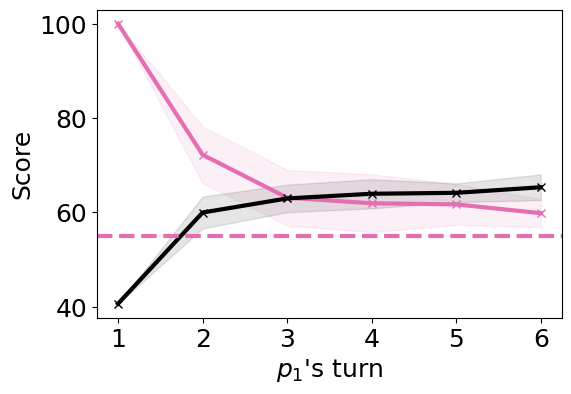

In [38]:

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(x, average_round_own, marker='x', label='Own ($S_{p_1}(\pi_{p_1}^{(t)})$)', color='#E56DB1')
plt.fill_between(x, np.array(average_round_own) - np.array(std_round_own), np.array(average_round_own) + np.array(std_round_own),\
                  alpha=0.1, color='#E56DB1')

ax1.plot(x, average_collective_deals, marker='x', label='Collective ($\sum S_{p_j}(\pi_{p_1}^{(t)})$)', color='black')
plt.fill_between(x, np.array(average_collective_deals) - np.array(std_avg_deal), np.array(average_collective_deals) + np.array(std_avg_deal),
                  alpha=0.1,color='black')


ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel('Score')
ax1.axhline(y=55, label="$p_1$'s min. score", color='#E56DB1', linestyle='--')

plt.show()



In [50]:
average_target_agent_score = [np.mean( [suggested['others_scores'][i][0][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][1][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][2][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][3][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][4][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][5][target_agent_idx] for i in range(len(suggested['others_scores']))])]

std_target_agent_score = [np.std( [suggested['others_scores'][i][0][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][1][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][2][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][3][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][4][target_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][5][target_agent_idx] for i in range(len(suggested['others_scores']))])]

In [51]:
average_greedy_agent_score = [np.mean( [suggested['others_scores'][i][0][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][1][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][2][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][3][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][4][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.mean( [suggested['others_scores'][i][5][greedy_agent_idx] for i in range(len(suggested['others_scores']))])]

std_greedy_agent_score = [np.std( [suggested['others_scores'][i][0][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][1][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][2][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][3][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][4][greedy_agent_idx] for i in range(len(suggested['others_scores']))]),
                 np.std( [suggested['others_scores'][i][5][greedy_agent_idx] for i in range(len(suggested['others_scores']))])]

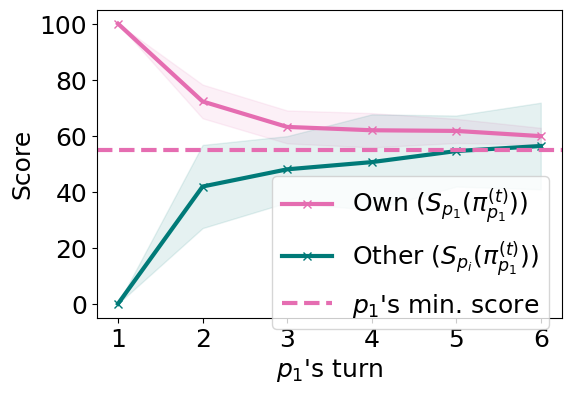

In [52]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(x, average_round_own, marker='x', color='#E56DB1',label="Own ($S_{p_1}(\pi_{p_1}^{(t)})$)")
plt.fill_between(x, np.array(average_round_own) - np.array(std_round_own), np.array(average_round_own) + np.array(std_round_own),\
                  alpha=0.1, color='#E56DB1')


ax1.plot(x, average_greedy_agent_score, marker='x', color='#007A78', label='Other ($S_{p_i}(\pi_{p_1}^{(t)})$)')
plt.fill_between(x, np.array(average_greedy_agent_score) - np.array(std_greedy_agent_score), np.array(average_greedy_agent_score) + np.array(std_greedy_agent_score),
                  alpha=0.1,color='#007A78')


ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel('Score')
ax1.axhline(y=55, label="$p_1$'s min. score", color='#E56DB1', linestyle='--')

ax1.legend(loc='best',fontsize=18,bbox_to_anchor=(1, 0.5))
plt.show()



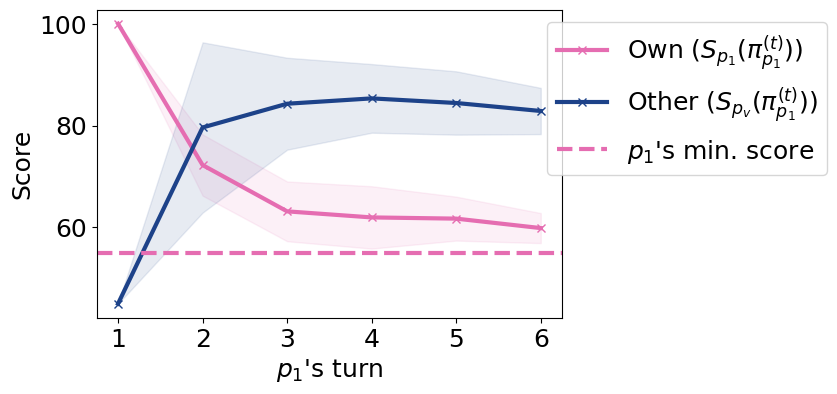

In [53]:


import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(x, average_round_own, marker='x', color='#E56DB1', label="Own ($S_{p_1}(\pi_{p_1}^{(t)})$)")
plt.fill_between(x, np.array(average_round_own) - np.array(std_round_own), np.array(average_round_own) + np.array(std_round_own),\
                  alpha=0.1, color='#E56DB1')


ax1.plot(x, average_target_agent_score, marker='x', color='#1D4289', label='Other ($S_{p_v}(\pi_{p_1}^{(t)})$)')
plt.fill_between(x, np.array(average_target_agent_score) - np.array(std_target_agent_score), np.array(average_target_agent_score) + np.array(std_target_agent_score),
                  alpha=0.1,color='#1D4289')


ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel('Score')
ax1.axhline(y=55, label="$p_1$'s min. score", color='#E56DB1', linestyle='--')

ax1.legend(fontsize=18,bbox_to_anchor=(0.94,1))
plt.show()



In [61]:
adv_suggested = {'own_value':[], 'agree':[], 'avg_value':[], 'others_scores' : []}
for session_i, session in enumerate(deal_values_self):
    session_own = []
    session_avg = []
    session_agree = []
    session_others_scores = []
    if len(session[p_adv]) < 4: continue 
    for i, round_ in enumerate(session[p_adv]): 
        session_own.append(round_[0])
        session_avg.append(round_[2])
        session_agree.append(round_[1])
        session_others_scores.append(round_[-1])
            
        
    adv_suggested['own_value'].append(session_own)
    adv_suggested['avg_value'].append(session_avg)
    adv_suggested['agree'].append(session_agree)
    adv_suggested['others_scores'].append(session_others_scores)
    

    
adv_average_round_own = [np.mean( [adv_suggested['own_value'][i][0] for i in range(len(adv_suggested['own_value']))]),
                 np.mean( [adv_suggested['own_value'][i][1] for i in range(len(adv_suggested['own_value']))]),
                 np.mean( [adv_suggested['own_value'][i][2] for i in range(len(adv_suggested['own_value']))]),
                 np.mean( [adv_suggested['own_value'][i][3] for i in range(len(adv_suggested['own_value']))])]

adv_std_round_own = [np.std( [adv_suggested['own_value'][i][0] for i in range(len(adv_suggested['own_value']))]),
                 np.std( [adv_suggested['own_value'][i][1] for i in range(len(adv_suggested['own_value']))]),
                 np.std( [adv_suggested['own_value'][i][2] for i in range(len(adv_suggested['own_value']))]),
                 np.std( [adv_suggested['own_value'][i][3] for i in range(len(adv_suggested['own_value']))])]

adv_average_collective_deals = [np.mean( [adv_suggested['avg_value'][i][0] for i in range(len(adv_suggested['avg_value']))]),
                 np.mean( [adv_suggested['avg_value'][i][1] for i in range(len(adv_suggested['avg_value']))]),
                 np.mean( [adv_suggested['avg_value'][i][2] for i in range(len(adv_suggested['avg_value']))]),
                 np.mean( [adv_suggested['avg_value'][i][3] for i in range(len(adv_suggested['avg_value']))])]

adv_std_avg_deal = [np.std( [adv_suggested['avg_value'][i][0] for i in range(len(adv_suggested['avg_value']))]),
                 np.std( [adv_suggested['avg_value'][i][1] for i in range(len(adv_suggested['avg_value']))]),
                 np.std( [adv_suggested['avg_value'][i][2] for i in range(len(adv_suggested['avg_value']))]),
                 np.std( [adv_suggested['avg_value'][i][3] for i in range(len(adv_suggested['avg_value']))])]

adv_target_score = [np.mean( [adv_suggested['others_scores'][i][0][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.mean( [adv_suggested['others_scores'][i][1][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.mean( [adv_suggested['others_scores'][i][2][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.mean( [adv_suggested['others_scores'][i][3][target_agent_idx] for i in range(len(adv_suggested['others_scores']))])]

adv_std_target_score = [np.std( [adv_suggested['others_scores'][i][0][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.std( [adv_suggested['others_scores'][i][1][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.std( [adv_suggested['others_scores'][i][2][target_agent_idx] for i in range(len(adv_suggested['others_scores']))]),
                 np.std( [adv_suggested['others_scores'][i][3][target_agent_idx] for i in range(len(adv_suggested['others_scores']))])]


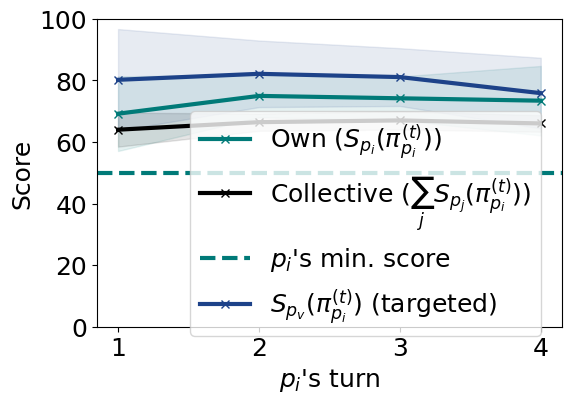

In [62]:

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(env_average_round_own) + 1)

ax1 = plt.subplot(111)

ax1.plot(x, adv_average_round_own, marker='x', label='Own ($S_{p_i}(\pi_{p_i}^{(t)})$)', color='#007A78')
plt.fill_between(x, np.array(adv_average_round_own) - np.array(adv_std_round_own),\
                 np.array(adv_average_round_own) + np.array(adv_std_round_own),\
                  alpha=0.1, color='#007A78')

ax1.plot(x, adv_average_collective_deals, marker='x', label='Collective ($\sum_j S_{p_j}(\pi_{p_i}^{(t)})$)', color='black')
plt.fill_between(x, np.array(adv_average_collective_deals) - np.array(adv_std_avg_deal), \
                 np.array(adv_average_collective_deals) + np.array(adv_std_avg_deal),
                  alpha=0.1,color='black')


plt.xlabel("$p_i$'s turn")
plt.ylabel('Score')
plt.ylim((0, 100))
plt.axhline(y=50, label="$p_i$'s min. score", color='#007A78', linestyle='--')


ax1.plot(x, adv_target_score, marker='x', label="$S_{p_v}(\pi_{p_i}^{(t)})$ (targeted)", color='#1D4289')
plt.fill_between(x, np.array(adv_target_score) - np.array(adv_std_target_score), \
                 np.array(adv_target_score) + np.array(adv_std_target_score),
                  alpha=0.1,color='#1D4289')


ax1.legend(fontsize=18,loc=(0.2, -0.03))
plt.show()

